# Metacritic All Time Games Statistics (1995 - 2018)

For this project, we used a dataset on Metacritic Games Reviews and Ratings from this kaggle page: https://www.kaggle.com/skateddu/metacritic-all-time-games-stats. Our goal is to ....


First, we import the necessary libraries:

In [19]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns; sns.set()
import numpy as np
import requests
import json
import pymongo
import scipy
from scipy import stats 
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import itertools 
from statsmodels.stats.power import TTestIndPower

In [20]:
# Functions

def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    return sample

def get_sample_mean(sample):
    return sum(sample) / len(sample)

#we are drawing 10,000 samples and taking the mean 1,000 times in order to run our test 
def create_sample_distribution(data, dist_size=1000, n=1000):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

def welch_t(a, b):
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p
    
def effect_size(a, b):
    e = a.mean()-b.mean()
    
    return e

Next we import the dataset and preview the dataframe in pandas.

In [21]:
# Import dataset csv and preview
df = pd.read_csv('metacritic_games.csv')
df.head()

,name,platform,developer,publisher,genre,players,rating,attribute,release_date,link,critic_positive,critic_neutral,critic_negative,metascore,user_positive,user_neutral,user_negative,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,01-Apr,T,NaN,"Aug 31, 1995",/game/pc/command-conquer,5,0,0,94,47,0,1,8.9
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,NaN,NaN,NaN,"Apr 30, 1995",/game/pc/full-throttle,6,2,0,86,18,1,0,8.7
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,01-Feb,T,NaN,"Sep 9, 1995",/game/playstation/battle-arena-toshinden,1,3,0,69,1,0,1,5.8
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,1 Player,K-A,NaN,"Feb 29, 1996",/game/pc/sid-meiers-civilization-ii,7,0,0,94,46,0,1,8.9
4,Quake,PC,id Software,id Software,Action,Jan-16,M,NaN,"Jun 22, 1996",/game/pc/quake,9,0,0,94,84,4,1,8.8


## Data Cleaning

### Removing incomplete rows and redundant columns

We begin data cleaning by dropping rows with missing values in developer and publisher.

In [22]:
# Drop rows with missing values in developer and publisher
df.dropna(subset=['developer', 'publisher'], inplace = True)
df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

The following columns are dropped as they are not relevant to our research question:

In [23]:
# Drop redundant columns
df = df.drop(['players', 'attribute', 'link', 'critic_positive',
              'critic_neutral', 'critic_negative','user_positive',
              'user_neutral', 'user_negative'], axis = 1)

### Obtaining Release Year

Next, we sliced the 'release_date' to obtain the year of release and replaced the column with the appropriate 'release_year' data.

In [24]:
# Change Release Date to Release Year
year_released = []
for i in range(0,len(df['release_date'])):    
    year_released.append(df.release_date[i].split()[2])
    
df['release_date'] = year_released
df.rename(columns={"release_date": "release_year"}, inplace = True)

# Change datatype from str to integer
df[['release_year']] = df[['release_year']].astype(int)

### Rating

Rating columns are adjusted by replacing the letters with the actual rating description, as follows:
* **E** = Everyone
* **EC** = Early Childhood 3+
* **E10+** = Everyone 10+
* **T** = Teen 13+
* **M** = Mature 17+
* **AO** = Adults Only 18+
* **RP** or **K-A** = Rating Pending
* **Null values** are replaced as Rating Pending

In [25]:
# Add Description to Rating column and remove null values
for rating in df['rating']:
    if rating == 'E':
        df.rating.replace(to_replace = rating, value = 'Everyone', inplace=True)
    elif rating == 'EC':
        df.rating.replace(to_replace = rating, value = 'Early Childhood 3+', inplace=True)
    elif rating == 'E10+':
        df.rating.replace(to_replace = rating, value = 'Everyone 10+', inplace=True)
    elif rating == 'T':
        df.rating.replace(to_replace = rating, value = 'Teen 13+', inplace=True)
    elif rating == 'M':
        df.rating.replace(to_replace = rating, value = 'Mature 17+', inplace=True)
    elif rating == 'AO':
        df.rating.replace(to_replace = rating, value = 'Adults Only 18+', inplace=True)
    elif rating == 'RP' or rating == 'K-A' or type(rating) == float:
        df.rating.replace(to_replace = rating, value = 'Rating Pending', inplace=True)

### Adjusting User Score

The user_score column contains 0 null values, however 'tbd' is present, representing the user score is to be determined. As there are 2000 + values of 'tbd', we will replace the values with random-assigned values with weighted probabilities from other user review scores

In [26]:
# Assign 'tbd' values with random-assigned values with weighted probablities
choice = sorted(df[df.user_score != 'tbd']['user_score'].unique())
prob = df[df.user_score != 'tbd']['user_score'].value_counts(normalize=True).sort_index()
df['user_score'] = df.user_score.map(lambda x: np.random.choice(choice, 1, p= prob)[0] if x == 'tbd' else x)

For comparison purposes, we will adjust the user_score to be in the same format as the metascore by multiplying all values by 10 as user_score is rated on a scale of 10 while metascore is rated on a scale of 100. Appropriate datatype conversion will be performed to the values.

In [27]:
# Change datatype from str to float
df[['user_score']] = df[['user_score']].astype(float)

# Change user_score from a scale of 10 to a scale of 100 by multiplying all values by 10
df['user_score'] = df['user_score'].apply(lambda x: x * 10 )

# Change datatype from float to int
df[['user_score']] = df[['user_score']].astype(int)

In [28]:
print(df.shape)
df.head()

(20380, 9)


,name,platform,developer,publisher,genre,rating,release_year,metascore,user_score
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,94,89
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,86,87
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,69,58
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,94,89
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,94,88


In [29]:
# platform_boolean = []
# for platform in df['platform']:
#     if platform == 'PC':
#         platform_boolean.append('PC')
#     else:
#         platform_boolean.append('Console')
# df['platform_bool'] = platform_boolean

# Segment our data into few ranges of years for analysis
year_boolean = []
for year in df['release_year']:
    if year == 2013 or year == 2014:
        year_boolean.append('13-14')
    elif year == 2015 or year == 2016:
        year_boolean.append('15-16')
    elif year == 2017 or year == 2018:
        year_boolean.append('17-18')
    elif year < 2013:
        year_boolean.append('Others')
df['year_bool'] = year_boolean

# To check average score between metascore and user score
avg_score = []
for i in range(0,len(df)):
    avg_score.append((df.metascore[i] + df.user_score[i])/2)
df['avg_score'] = avg_score

# To display the description of the scoring system
score_indication = []
for score in df['avg_score']:
    if score >= 90:
        score_indication.append('Universal Acclaim')
    elif score >= 75 and score <= 89:
        score_indication.append('Favorable')
    elif score >= 50 and score <= 74:
        score_indication.append('Average')
    elif score >= 20 and score <= 49:
        score_indication.append('Unfavorable')
    else:
        score_indication.append('Overwhelming Dislike')
df['score_indication'] = score_indication 

In [30]:
# Re-index the column order
df = df.reindex(columns=['name', 'platform', 'developer','publisher',
                         'genre', 'rating', 'release_year','year_bool', 
                         'metascore', 'user_score', 'avg_score', 'score_indication'])
df.head()

,name,platform,developer,publisher,genre,rating,release_year,year_bool,metascore,user_score,avg_score,score_indication
0,Command & Conquer,PC,Westwood Studios,Virgin Interactive,Sci-Fi,Teen 13+,1995,Others,94,89,91.5,Universal Acclaim
1,Full Throttle,PC,LucasArts,LucasArts,Adventure,Rating Pending,1995,Others,86,87,86.5,Favorable
2,Battle Arena Toshinden,PS,Tamsoft,SCEA,Action,Teen 13+,1995,Others,69,58,63.5,Average
3,Sid Meier's Civilization II,PC,MPS Labs,MicroProse,Strategy,Rating Pending,1996,Others,94,89,91.5,Universal Acclaim
4,Quake,PC,id Software,id Software,Action,Mature 17+,1996,Others,94,88,91.0,Universal Acclaim


Great! We now have a clean dataframe in the right format with no missing values. The dataframe has a shape of **12 columns x 20380 rows**. We can now begin our data analysis and hypothesis testing.

# Data Analysis 

## Hypothesis 1 (ANOVA Test)

Due to the introduction of new genre in 2015 , expectation of potential customers towards the games is high. 
Thus, they might give lower rating to Action game.
* **H0 : The user rating of Action in Year 13-14 , Year 15-16 and Year 17-18 have no differences.**
* **H1 : The user rating of Action in Year 13-14 , Year 15-16 and Year 17-18 have significant difference.**

In [31]:
actiondf = df[df.genre == 'Action']
actiondf["user_score"].groupby([df.year_bool,df.genre]).describe()

,,count,mean,std,min,25%,50%,75%,max
year_bool,genre,,,,,,,,
13-14,Action,780.0,66.532051,14.273246,10.0,60.0,70.0,76.0,91.0
15-16,Action,943.0,66.439024,13.302309,4.0,61.0,69.0,76.0,92.0
17-18,Action,1089.0,66.822773,14.308471,10.0,60.0,70.0,77.0,92.0
Others,Action,4288.0,70.090718,14.533117,12.0,63.0,74.0,80.0,92.0


In [32]:
actiondf_1314 = actiondf[actiondf['year_bool'] == '13-14']
actiondf_1516 = actiondf[actiondf['year_bool'] == '15-16']
actiondf_1718 = actiondf[actiondf['year_bool'] == '17-18']

In [33]:
sample_1314 = actiondf_1314.sample(100)
sample_1516 = actiondf_1516.sample(100)
sample_1718 = actiondf_1718.sample(100)

sample_merged = pd.concat([sample_1314, sample_1516, sample_1718])

In [34]:
sample_merged['user_score'].groupby(by = sample_merged.year_bool).describe()

,count,mean,std,min,25%,50%,75%,max
year_bool,,,,,,,,
13-14,100.0,66.48,13.659259,13.0,62.00,69.5,75.00,87.0
15-16,100.0,63.35,13.056501,23.0,58.00,64.0,73.25,85.0
17-18,100.0,67.05,14.438567,12.0,60.75,69.5,76.25,87.0


## Normality Test

ANOVA Assumptions
1. The experimental errors of your data are normally distributed
2. Equal variances between treatments Homogeneity of variances Homoscedasticity
3. Independence of samples Each sample is randomly selected and independent.

In [35]:
scipy.stats.normaltest(sample_1314.user_score)
scipy.stats.normaltest(sample_1516.user_score)
scipy.stats.normaltest(sample_1718.user_score)

NormaltestResult(statistic=34.28948351633284, pvalue=3.582063338012057e-08)

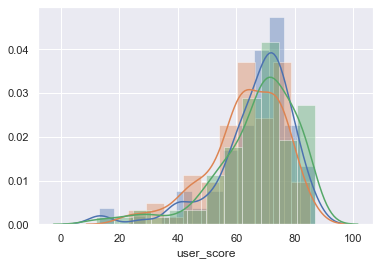

In [36]:
sns.distplot(sample_1314.user_score)
sns.distplot(sample_1516.user_score)
sns.distplot(sample_1718.user_score)

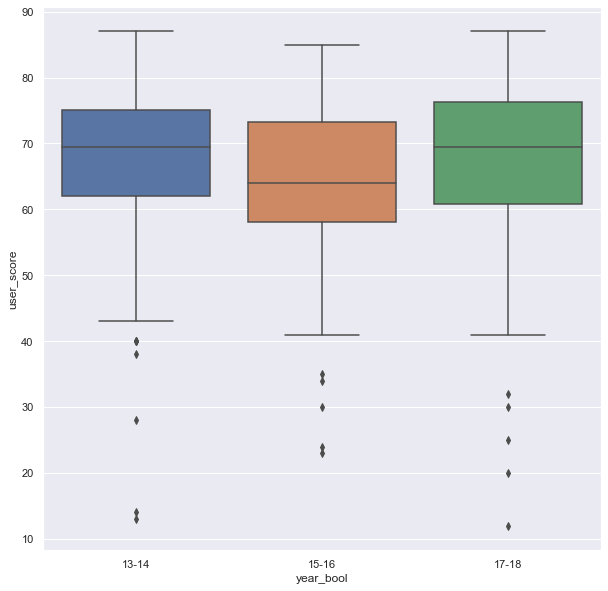

In [37]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='year_bool', y='user_score', data=sample_merged)

From the graph above, we can improve it  by putting more samples. 
But, we assume this is ok for now.

We tested ANOVA test.

In [38]:
formula = 'user_score ~ C(year_bool)'
lm = ols(formula, sample_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                 df        sum_sq     mean_sq         F    PR(>F)
C(year_bool)    2.0    793.726667  396.863333  2.105302  0.123623
Residual      297.0  55986.460000  188.506599       NaN       NaN


We found out there are not any differences between years (0.05 < 0.25).
To check further, We took "Tukey Test" to see the relationship between years in details.

In [39]:
mc = MultiComparison(sample_merged.user_score, sample_merged.year_bool)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 13-14  15-16    -3.13 0.2424 -7.7039 1.4439  False
 13-14  17-18     0.57    0.9 -4.0039 5.1439  False
 15-16  17-18      3.7 0.1389 -0.8739 8.2739  False
---------------------------------------------------


Tukey test confirmed us that there are no differences.
Therefore, we cannot reject null hypothesis and 
We concluded that " The user rating of Action in Year 13-14 , Year 15-16 and Year 17-18 have no differences."

## Hypothesis 2 : Atlus vs Zen Studios vs Ubisoft (ANOVA)

For this hypothesis test, we aim to compare 3 publishing powerhouses in the gaming industry, namely Atlus, Ubisoft and Zen Studios. 
* Atlus is a japanese company, known for their Sega games like Super Sonic and work closely with Nintendo games developer.
* Ubisoft is one of the top gaming developer and publisher, known for famous RPG games like the Assassin's Creed and Tom Clancy series.
* Zen Studios is a Hungarian company focuses on simplistic revamped classic games like Pinball and CastleStorm.

The goal of this experiment is to see which publisher/distributer performs better with the critics, given their reputation.

* **H0 : The 3 companies perform equally well on metascore**
* **H1 : The 3 companies do not perform equally well on metascore**

In [40]:
df_ubisoft = df[df.publisher == 'Ubisoft']
df_atlus = df[df.publisher == 'Atlus']
df_zen = df[df.publisher == 'Zen Studios']

In [41]:
sample_ubisoft = df_ubisoft.sample(50)
sample_atlus = df_atlus.sample(50)
sample_zen = df_zen.sample(50)

sample_merged = pd.concat([sample_ubisoft,sample_atlus, sample_zen])

We first plot the boxplot comparison to visually inspect the difference between mean, as below:

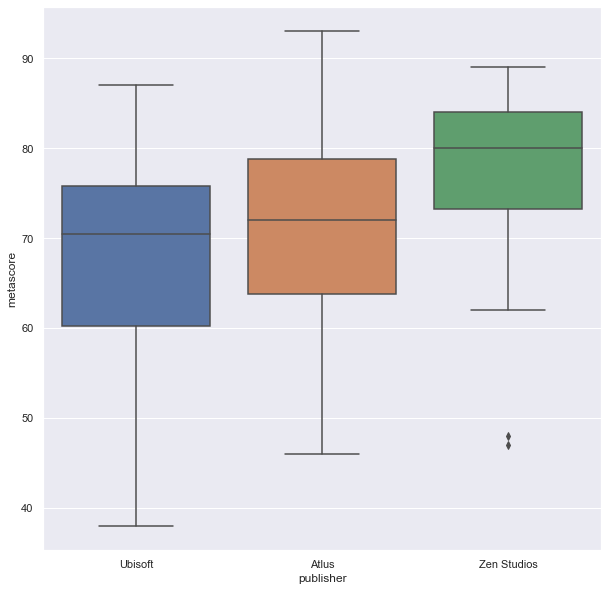

In [42]:
fig = plt.subplots(figsize = (10,10))
sns.boxplot(x='publisher', y='metascore', data=sample_merged)

Before proceeding to ANOVA testing, we do a quick normality check to see if we satisfies the normality condition for ANOVA.

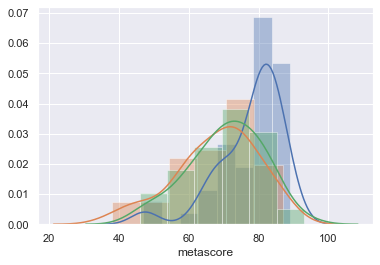

In [43]:
sns.distplot(sample_zen.metascore)
sns.distplot(sample_ubisoft.metascore)
sns.distplot(sample_atlus.metascore)

In [44]:
scipy.stats.normaltest(sample_zen.metascore)
scipy.stats.normaltest(sample_atlus.metascore)
scipy.stats.normaltest(sample_ubisoft.metascore)

NormaltestResult(statistic=3.1724650436109045, pvalue=0.20469534609798715)

As we are comparing 3 groups, we take 50 random samples from each group and conduct an ANOVA to check for statistically siginificant F-value and P-value to proceed with our analysis.

In [45]:
formula = 'metascore ~  C(publisher)'
lm = ols(formula, sample_merged).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                 df    sum_sq      mean_sq          F   PR(>F)
C(publisher)    2.0   2526.24  1263.120000  11.192324  0.00003
Residual      147.0  16589.82   112.855918        NaN      NaN


From the ANOVA result, we can see a p-value of 0.005, which indicates statistical significance as it is below alpha value of 0.05. We then proceed to perform a Tukey multiple comparison test.

In [46]:
mc = MultiComparison(sample_merged.metascore, sample_merged.publisher)
mc_results = mc.tukeyhsd()
print(mc_results)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2   meandiff p-adj  lower  upper  reject
--------------------------------------------------------
  Atlus     Ubisoft    -2.64  0.432 -7.671  2.391  False
  Atlus Zen Studios     7.08 0.0031  2.049 12.111   True
Ubisoft Zen Studios     9.72  0.001  4.689 14.751   True
--------------------------------------------------------


From the Tukey results table, we can see that for Atlus vs Ubisoft, the null hypothesis was not rejected while the null hypothesis was rejected when Zen Studios was compared against Atlus and Ubisoft.

In [47]:
print(f"The effect size observed between Atlus and Zen Studios is {(cohen_d(sample_atlus.metascore, sample_zen.metascore))}")
print(f"The effect size observed between Ubisoft and Zen Studios is {(cohen_d(sample_ubisoft.metascore, sample_zen.metascore))}")

The effect size observed between Atlus and Zen Studios is 0.707897434536649
The effect size observed between Ubisoft and Zen Studios is 0.9156797971347684


## Hypothesis 3 - Investigate to what extent it is worth investing PR spend in engaging video game reviewers in the PC market

**Business Question**

Do professional reviewers give consistently higher ratings for PC games than users in a **significant** way? 

**Business Decsision**

Professional reviewers help games sales for PCs, however to what extent is it worth engaging PR spend into engaging with professional reviews, as opposed to investing more in user generated content on social media

**Data Science Question**

H0 = ReviewerRatingMean = UserRatingMean

H1 = ReviewerRatingMean > UserRatingMean

Effect size (Cohen's D) > 0.8

Type 1 error rate = 0.05
Type 2 error rate = 0.9

In [48]:
#isolate PC games only for the dataset

PC_df = df[df.platform == 'PC']

reviewer_population = PC_df["metascore"] #reviewer ratings
user_population = PC_df["user_score"] #user ratings

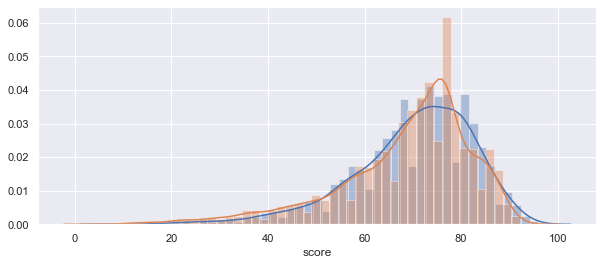

In [49]:
plt.figure(figsize=(10,4))
reviewer_population_plot = sns.distplot(reviewer_population, axlabel = "score");
user_population_plot = sns.distplot(user_population, axlabel = "score");
plt.show()

Looking at the data we can see that it is noisy and that it 'looks' like there is no significant difference between user ratings (orange) and reviewer ratings (blue). We need to investigate more deeply to see if thi is really the case.

## Test Choice
Looking at some summary statistics for the variables we are interested in:

In [50]:
round(reviewer_population.var())

157

In [51]:
round(user_population.var())

194

Although the population sizes are the same and we can draw the same sample sizes from both, the variance is significantly different making this suitable for a Welch's T-Test.

### How many samples do we need to use in order to find the effect we are looking for, if it is there?

In [52]:
#Power analysis in order to calculate the number of samples needed to confident we can observe the effect 
#we are looking for, if it exists

analysis = TTestIndPower()
effect = 0.8 #we are looking for a significant increase which in term of Cohen's D means >= 0.8
alpha = 0.05 #this is the equivalent to a 5% type 1 error rate (false positive)
power = 0.9 #this is the equivalent to a 10% type 2 error rate (false negative)

required_sample_size = analysis.solve_power(effect, 
                                    power = power, 
                                    nobs1 = None, 
                                    ratio = 1, 
                                    alpha = alpha)
round(required_sample_size)

34

We only need 34 random samples from the population in order to observe a 'significant' effect if it exists, however given the simplicity of the problem, size of the data set and how cheap processing power is these days we can do more than this for the test.

## Creating the Samples for the test

In [53]:
#Here we are creating sample distributions for both user and editor reviews, 
#we are doing this 1,000 time across 1,000 time each 
user_sample_dist = create_sample_distribution(user_population) #user review sample distribution
meta_sample_dist = create_sample_distribution(reviewer_population) #professional reviewer sample distribution

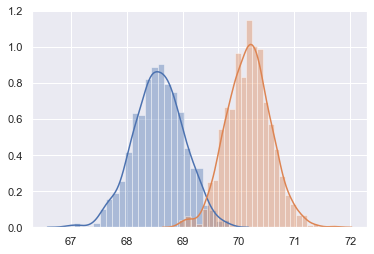

In [54]:
#Here we plot both sample distributions and we can see a marked difference between each sample
sns.distplot(user_sample_dist);
sns.distplot(meta_sample_dist);

There is a marked difference between each sampling distribution suggesting a larger difference than that given by the population distribution above.

In [55]:
#convert data in Pandas format for analysis

meta_sample_dist_series = pd.Series(meta_sample_dist)
user_sample_dist_series = pd.Series(user_sample_dist)

In [56]:
#Calculate P value
p_value(meta_sample_dist_series, user_sample_dist_series)

0.0

In [57]:
#Calculate Effect size
cohen_d(meta_sample_dist_series, user_sample_dist_series)

3.7832734154414043

We can confidently reject the null hypothesis where we can say that reviwers do give higher reviews than users in a statistically significant way. Also, the effect is significant (>0.8). 

## Is the test valid?

We have to check that the sample distributions obey the normality condition in order to ensure our test is valid. We do this by running QQ plots on the sampling distributions and if they are a straightline then the sample data is normally distributed.

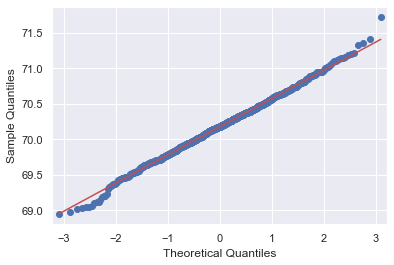

In [58]:
sm.qqplot(meta_sample_dist_series, line = 's'); # professional reviwer QQ plot

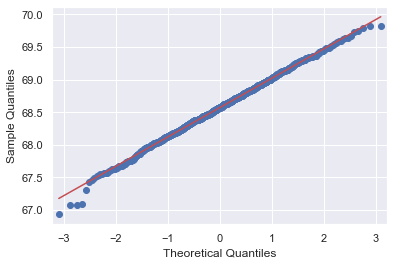

In [59]:
sm.qqplot(user_sample_dist_series, line = 's'); #user review QQ plot

As we can see we have straigt lines in both cases and so the test is valid.